# Two chargers stochastic simulation

* Vehicles arrive at rate $\lambda$ uniformly distributed in [0,1].
* There are two chargers C1 and C2 with infinite capacity.
* Vehicles require a charging time $\exp(\mu)$ after which they depart.
* Initially, they choose the nearest charger.

In [85]:
using Distributions, Plots

#Objeto que representa al cargador.
mutable struct Charger
    position::Float64
    currentOccupation::Integer
    currentPrice::Float64
    totalPower::Float64
    mu::Float64
    Charger(position::Float64) = new(position,0,0.0,0.0, 0.0)
end

#Objeto que representa al EV
mutable struct EV
    arrivalTime::Float64
    arrivalPosition::Float64
    requiredEnergy::Float64
    assignedCharger::Union{Charger,Nothing}
    departureTime::Float64
    EV(arrivalTime::Float64,arrivalPosition::Float64,requiredEnergy::Float64) = new(arrivalTime,arrivalPosition,requiredEnergy,nothing,NaN)
end

#auxiliar
function compute_distance(ev::EV,c::Charger)
    return abs(ev.arrivalPosition - c.position)
end

function update_energy!(ev::EV,dt::Float64)
    ev.requiredEnergy = ev.requiredEnergy-dt
    # min {ev.assignegCharger.totalPower / ev.assignegCharger.currentoccupation, 1};
end


update_energy! (generic function with 1 method)

In [2]:
function TimeForNextEvent()
    
    dt,event = findmin([timeForNextArrival, timeForNextDeparture]);
        
    return dt, event;
end

TimeForNextEvent (generic function with 1 method)

In [3]:
function UpdateEnergyForAllCars()
     map(ev->update_energy!(ev,timeForEvent), chargingEVs)
end

UpdateEnergyForAllCars (generic function with 1 method)

In [4]:
function CreateEV()
    return EV(currentTime,rand(dist_position), rand(dist_energy))
end

CreateEV (generic function with 1 method)

In [5]:
function AddEVToChargingEVList(ev::EV)
     push!(chargingEVs,ev)
end

AddEVToChargingEVList (generic function with 1 method)

In [6]:
function GetIndexToNearestChargerToCar(ev::EV)
    
     distances = compute_distance.(Ref(ev), chargers)  #el Ref es para que el . opere solo sobre los chargers
     distance,idx = findmin(distances)
    
    return distance, idx;
    
end

GetIndexToNearestChargerToCar (generic function with 1 method)

In [106]:
function GetOptimalChargerToCar(ev::EV)
    
    min_price = Inf;
    optimal_charger = nothing;
    
    for charger in chargers
        
        distance = compute_distance(ev, charger);
        mu = charger.mu;
        
        price = distance + 1 * mu;
        
        if price < min_price
            min_price = price;
            optimal_charger = charger;
        end
        
    end
    
    return optimal_charger;
    
end

GetOptimalChargerToCar (generic function with 1 method)

In [53]:
function IncreaseChargerOccupation(myCharger)
        
    index = findfirst(aCharger -> aCharger.position == myCharger.position, chargers)
    
    chargers[index].currentOccupation = chargers[index].currentOccupation + 1
    
end

IncreaseChargerOccupation (generic function with 1 method)

In [9]:
function AssignOptimalChargerToCar(ev::EV)
    
    charger = GetOptimalChargerToCar(ev);
       
    ev.assignedCharger = charger;
    
    IncreaseChargerOccupation(charger);
    
end

AssignOptimalChargerToCar (generic function with 1 method)

In [10]:
function IsACarCharging()
    return c1.currentOccupation + c2.currentOccupation > 0;
end

IsACarCharging (generic function with 1 method)

In [11]:
function GetCarAndTimeRemainingForClosestDeparture()
    
    global timeForNextDeparture, nextCarToFinish;
    
    timeForNextDeparture,nextCarToFinish = findmin([ev.requiredEnergy for ev in chargingEVs])
    
    return timeForNextDeparture, nextCarToFinish;
    
end

GetCarAndTimeRemainingForClosestDeparture (generic function with 1 method)

In [12]:
function SetDepartureTimeOfEV(ev_index)
    chargingEVs[ev_index].departureTime = currentTime;
end

SetDepartureTimeOfEV (generic function with 1 method)

In [13]:
function AddEVToFinishedEVsList(ev_index)
     push!(finishedEVs, chargingEVs[ev_index])
end

AddEVToFinishedEVsList (generic function with 1 method)

In [14]:
function DecreaseChargerOccupationOfEV(ev_index)
    chargingEVs[ev_index].assignedCharger.currentOccupation = chargingEVs[ev_index].assignedCharger.currentOccupation - 1;
end

DecreaseChargerOccupationOfEV (generic function with 1 method)

In [15]:
function RemoveEVFromChargingEVList(ev_index)
    deleteat!(chargingEVs,ev_index);
end

RemoveEVFromChargingEVList (generic function with 1 method)

In [16]:
function UpdateGraphsData()
     
    push!(T,currentTime) 
    
    for i = 1:amountOfChargers
        push!(Occupations[i], chargers[i].currentOccupation);
    end

end

UpdateGraphsData (generic function with 1 method)

In [17]:
function AssignCarAndTimeRemainingForClosestDepartureIfExists()

    global timeForNextDeparture, nextCarToFinish;
    
    if IsACarCharging()
        timeForNextDeparture, nextCarToFinish = GetCarAndTimeRemainingForClosestDeparture();
    else
        timeForNextDeparture = Inf
        nextCarToFinish = nothing
    end
    
end

AssignCarAndTimeRemainingForClosestDepartureIfExists (generic function with 1 method)

In [78]:
function UpdateChargerPrice(charger)
    
    old_mu = charger.mu;
    old_totalPower = charger.totalPower;
    
    charger.mu = old_mu + timeForEvent * (charger.currentOccupation - old_totalPower);
    
    charger.totalPower = old_totalPower + timeForEvent * (old_mu - old_totalPower);
    
end

UpdateChargerPrice (generic function with 1 method)

In [79]:
function UpdatePricesAndPower()
    
# Guardo mu anterior para calcular nuevo s
        
# Nuevo mu es mu anterior + timeForEvent * (occupation_c - s_c) | por cada cargador
        
# Nuevo s es s anterior + timeForEvent * (mu anterior - s_anterior) | por cada cargador
    
    for charger in chargers
        UpdateChargerPrice(charger);   
    end
    
end

UpdatePricesAndPower (generic function with 1 method)

In [80]:
function Simulate()
    
    global currentTime;
    global timeForEvent;
    global timeForNextArrival;
    global timeForNextDeparture;
    global nextEvent;
        
    while currentTime < finalTime
    
        currentTime = currentTime + timeForEvent
        
        #Restar tiempo de departure
        timeForNextArrival = timeForNextArrival - timeForEvent #DUDA

        UpdateEnergyForAllCars();
        
        UpdatePricesAndPower();
        
            # Guardo mu anterior para calcular nuevo s
        
            # Nuevo mu es mu anterior + timeForEvent * (occupation_c - s_c) | por cada cargador
        
            # Nuevo s es s anterior + timeForEvent * (mu anterior - s_anterior) | por cada cargador

        if nextEvent == Arrival

           new_ev = CreateEV();
        
           AddEVToChargingEVList(new_ev);

           AssignOptimalChargerToCar(new_ev);

           timeForNextArrival = rand(dist_arrivals);

        elseif nextEvent == Departure 
            
            SetDepartureTimeOfEV(nextCarToFinish);
        
            AddEVToFinishedEVsList(nextCarToFinish);
        
            DecreaseChargerOccupationOfEV(nextCarToFinish);
        
            RemoveEVFromChargingEVList(nextCarToFinish);

        end

        UpdateGraphsData();

        AssignCarAndTimeRemainingForClosestDepartureIfExists();

        timeForEvent, nextEvent = TimeForNextEvent();


     end
    
end

Simulate (generic function with 1 method)

In [107]:
#using Printf
lambda = 100.0 #autos por hora
mu= 0.5   #2 horas de carga

finalTime = 100

c1 = Charger(0.5)
c2 = Charger(1.0)

c1.mu = 0.0;
c2.mu = 0.0;

chargers = [c1;c2]

amountOfChargers = size(chargers)[1];

chargingEVs = EV[]   #lista de vehiculos en el sistema

finishedEVs = EV[] #lista de vehiculos que terminaron (para estadistica)

dist_arrivals = Exponential(1/lambda)   #hay que pasarle la media no el parámetro
dist_energy = Exponential(1/mu)   #hay que pasarle la media no el parámetro
dist_position = Uniform(0,1)

currentTime = 0.0
T=[currentTime]

#Ocupacion por cargador
C1=[c1.currentOccupation]
C2=[c2.currentOccupation]

Occupations = [C1, C2];

timeForNextArrival = rand(dist_arrivals)
timeForNextDeparture = Inf

Arrival = 1;
Departure = 2;

nextCarToFinish = nothing  #Esto apunta a un vehiculo del array EVs que es el de menor remanente

timeForEvent, nextEvent = TimeForNextEvent();

Simulate();

In [108]:
mean(Occupations[1])

97.49150905023389

In [109]:
mean(Occupations[2])

97.26494813910921

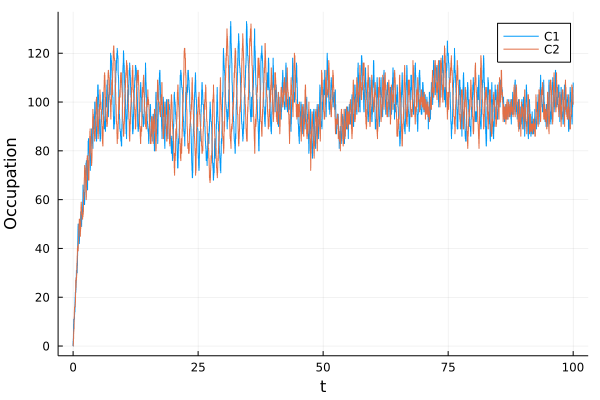

In [110]:
plot(T, Occupations[1], lt=:steppost, label = "C1")
plot!(T, Occupations[2], lt=:steppost, label = "C2")
xlabel!("t")
ylabel!("Occupation")

In [111]:
for charger in chargers
   println(charger.totalPower) 
end

98.13069470633299
97.78350749699


In [112]:
for charger in chargers
   println(charger.mu) 
end

96.66156595670759
97.12133358500758
